In [89]:
%load_ext autoreload
%autoreload
%matplotlib widget
import importlib
from SOAEpeaks import load_df
import phaseco as pc
from phaseco import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian
importlib.reload(pc)
import ipywidgets as widgets
from IPython.display import display


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# Get different species
df = load_df(laptop=True, dfs_to_load=["Curated Data"])
wf_list = []
for species in ['Anolis', 'Owl', 'Human']:
    df_species = df[df['species'] == species]
    for i in range (3):
        row = df_species.iloc[i]
        wf_title = row['filepath'].split('\\')[-1]
        wf_list.append((row['wf'], row['sr'], wf_title, species))
# Get first anolis
wf = wf_list[0][0]
fs = wf_list[0][1]
wf_title = wf_list[0][2]
del df

Loading Curated Data


ArrowMemoryError: malloc of size 2147483648 failed

In [ ]:
"Colossogram Plot Function"
def colossogram(coherences, f, xis, tau, wf_title=None, max_khz=None):
    # make meshgrid
    xx, yy = np.meshgrid(xis, f / 1000) 
    
    # plot the heatmap
    vmin = 0
    vmax = 1
    cmap = "magma"
    heatmap = plt.pcolormesh(xx, yy, coherences, vmin=vmin, vmax=vmax, cmap=cmap, shading='nearest')

    # get and set label for cbar
    cbar = plt.colorbar(heatmap)
    cbar.set_label("Vector Strength")
    if max_khz is not None:
        plt.ylim(0, max_khz)
    else:
        plt.ylim(0, 6)
    # set axes labels and titles
    plt.xlabel(rf"$\xi$ [ms]")
    plt.ylabel("Frequency [kHz]")
    if wf_title is not None:
        title = rf"{wf_title}"
    else:
        title = rf"Colossogram with $\tau={tau:.3f}$"
    plt.title(title)
      

In [ ]:
"Basic Colossogram calculations"
tauS = 2**11
tau = tauS / fs
xis = np.linspace(0.0025, tau, 30)
max_xiS = max(xis) * fs
f = rfftfreq(tauS, 1/fs)
# Make sure we have a consistent number of segments to take vector strenght over since this will change with xi
N_segs = int((len(wf) - tauS) / max_xiS)    


In [ ]:
"Basic Plot"
rho = None
coherences = np.zeros((len(f), len(xis)))
for i, xi in enumerate(xis):
    coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
    
plt.figure(figsize=(12, 6))
colossogram(coherences, f, xis, tau, wf_title=wf_title)
plt.show()

In [ ]:
"Rho Plot"
rho = 1
coherences_rho = np.zeros((len(f), len(xis)))
for i, xi in enumerate(xis):
    coherences_rho[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
plt.figure(figsize=(12, 6))
colossogram(coherences, f, xis, tau, wf_title=wf_title)
plt.suptitle('$\rho = 1$')
plt.show()

In [ ]:
"Sigma Plot"
coherences_sigma = np.zeros((len(f), len(xis)))
sigma = tau / 10
for i, xi in enumerate(xis):
    coherences_sigma[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, win_type=("gauss", sigma * fs))[1]
plt.figure(figsize=(12, 6))
colossogram(coherences, f, xis, tau, wf_title=wf_title)
plt.suptitle(rf'$Constant \sigma = {sigma:.5f}$')
plt.show()

In [ ]:
"Calculate sigma comparison"
sigma_coherences_list = []
tauS = 2**11
tau = tauS / 44100
xis = np.linspace(0.0025, tau, 30)
sigmas = np.linspace(0.0025/4, tau/8, 9)
for i, sigma in enumerate(sigmas):
    coherences = np.zeros((len(f), len(xis)))
    for j, xi in enumerate(xis):
        coherences[:, j] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, win_type=("gauss", sigma * fs))[1]
    sigma_coherences_list.append((sigma, coherences))

In [ ]:
"Plot sigma comparison"
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (sigma, coherences) in enumerate(sigma_coherences_list):
    plt.subplot(3, 3, i + 1)
    colossogram(coherences, f, xis, tau, wf_title=rf'$\sigma={sigma:.5f}$')
plt.suptitle(rf'Colossogram $\sigma$ comparison ($\tau={tau:.3f}$, {wf_title})')
plt.tight_layout()
plt.savefig(rf'Colossogram sigma comparison.png', dpi=300)
plt.show()

In [81]:
"Calculate rho comparison"
sigma_coherences_list = []
tauS = 2**11
tau = tauS / 44100
xis = np.linspace(0.0025, tau, 30)
rhos = [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.5, 3, 5]
for i, rho in enumerate(rhos):
    coherences = np.zeros((len(f), len(xis)))
    for j, xi in enumerate(xis):
        coherences[:, j] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
    sigma_coherences_list.append((rho, coherences))

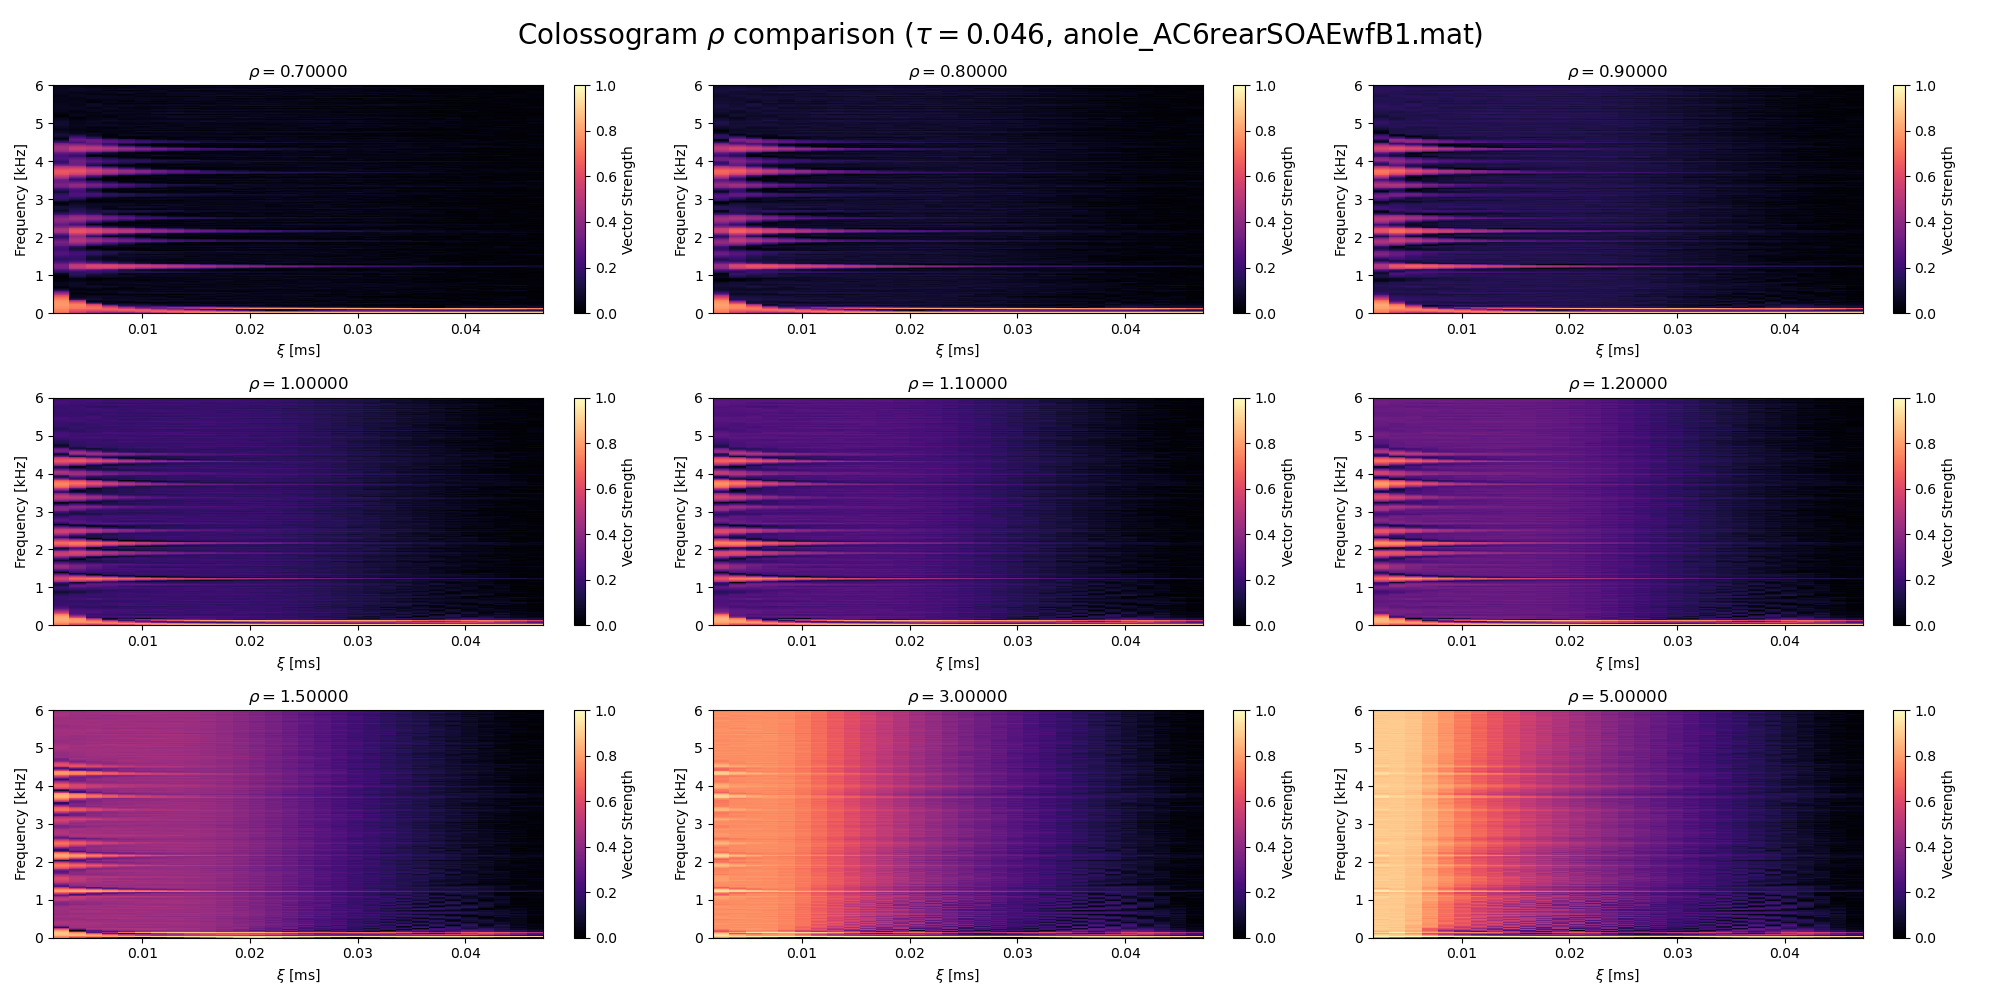

In [82]:
"Plot rho comparison"
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (rho, coherences) in enumerate(sigma_coherences_list):
    plt.subplot(3, 3, i + 1)
    colossogram(coherences, f, xis, tau, wf_title=rf'$\rho={rho:.5f}$')
plt.suptitle(rf'Colossogram $\rho$ comparison ($\tau={tau:.3f}$, {wf_title})', fontsize=20)
plt.savefig(rf'Colossogram rho comparison.png', dpi=300)
plt.tight_layout()
plt.show()

In [84]:
"Calculate species comparison (rho=1)"
rho = 1
species_coherences_list = []
for wf, fs, wf_title, species in wf_list:
    tauS = 2**11
    tau = tauS / 44100 # Everyone uses the same tau
    xis = np.linspace(0.0025, tau, 50) # And xis
    if fs != 44100: # Prioritize homogenity with other species over ideal 2**N tau
        tauS = int(tau * fs)
    max_xiS = max(xis) * fs
    f = rfftfreq(tauS, 1/fs)
    # Make sure we have a consistent number of segments to take vector strength over since this will change with xi
    N_segs = int((len(wf) - tauS) / max_xiS)    
    coherences = np.zeros((len(f), len(xis)))
    for i, xi in enumerate(xis):
        coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
    species_coherences_list.append((coherences, f, xis, tau, wf_title, species))

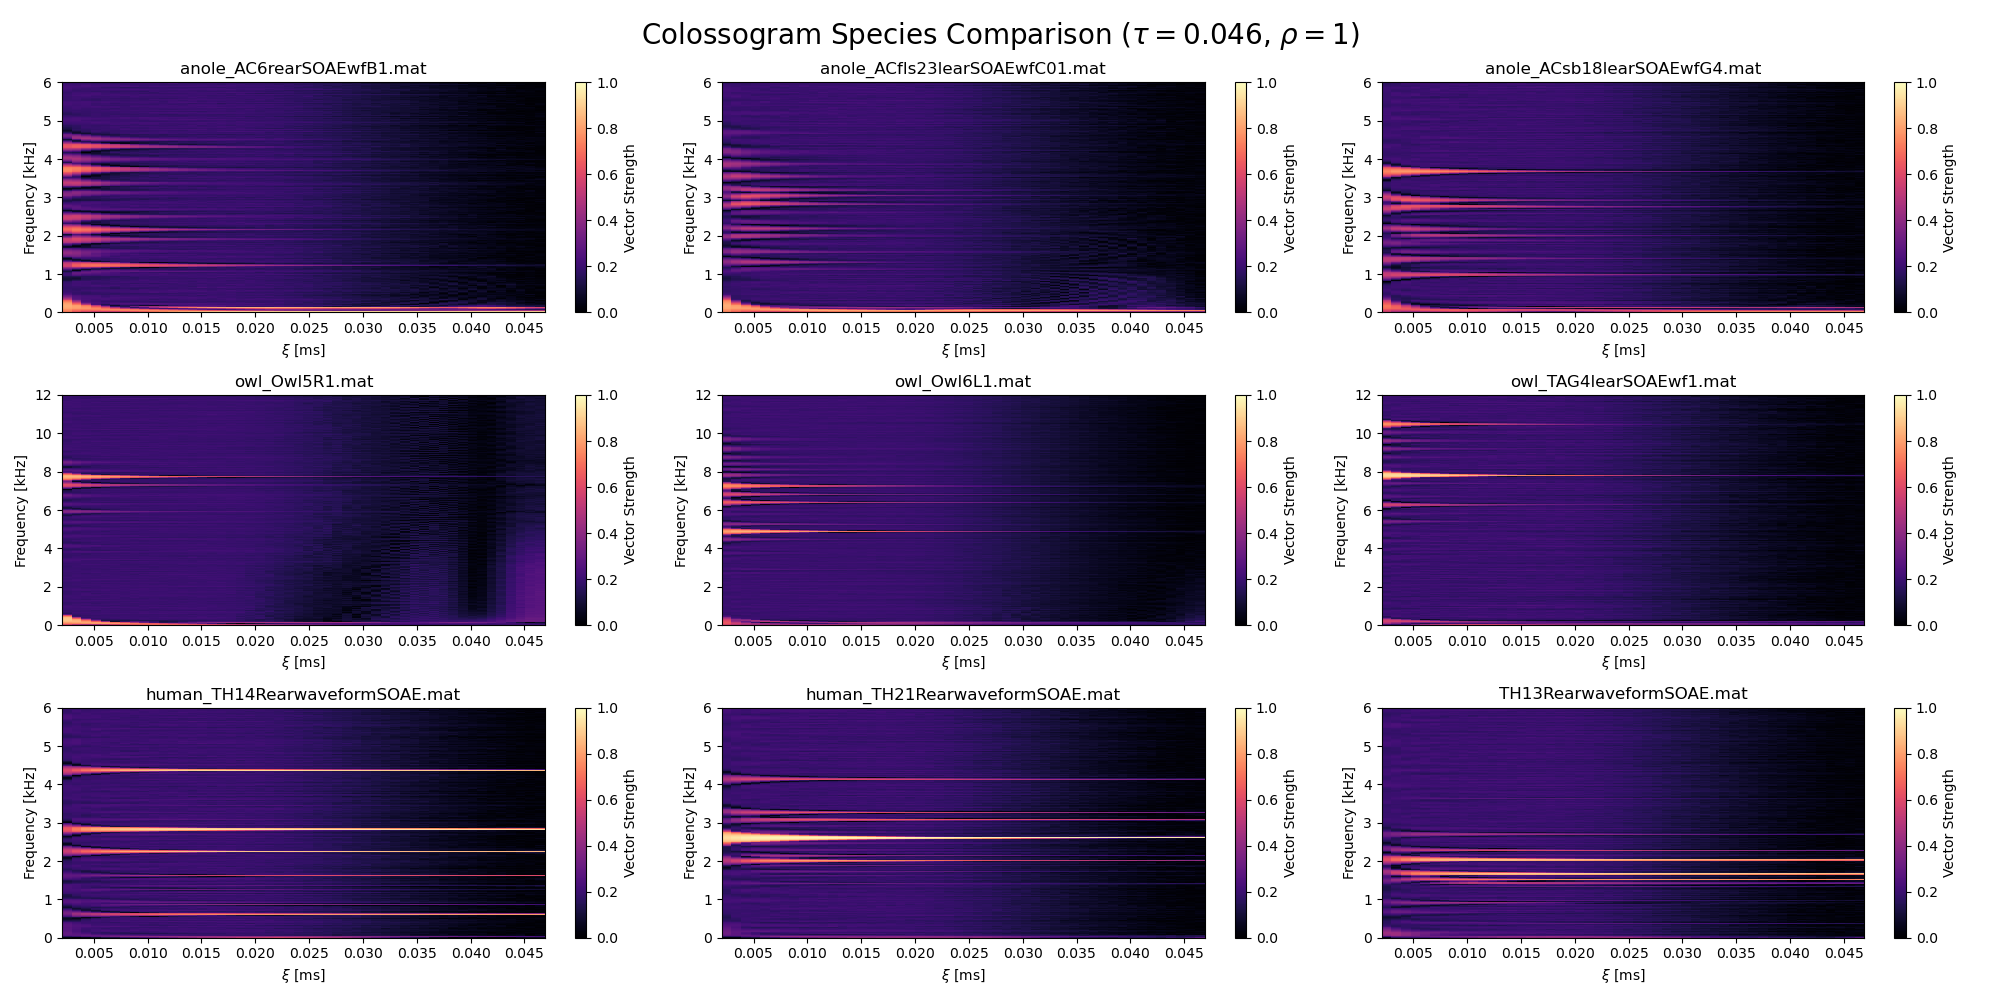

In [85]:
"Plot different species comparison (rho=1)"
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (coherences, f, xis, tau, wf_title, species) in enumerate(species_coherences_list):
    plt.subplot(3, 3, i + 1)
    if species == "Owl":
        max_khz = 12
    else:
        max_khz = 6
    colossogram(coherences, f, xis, tau, wf_title=wf_title, max_khz=max_khz)
plt.suptitle(rf'Colossogram Species Comparison ($\tau={tau:.3f}$, $\rho = {rho}$)', fontsize=20)
plt.tight_layout()
plt.savefig(rf'Colossogram species comparison (rho={rho}).png', dpi=300)
plt.show()

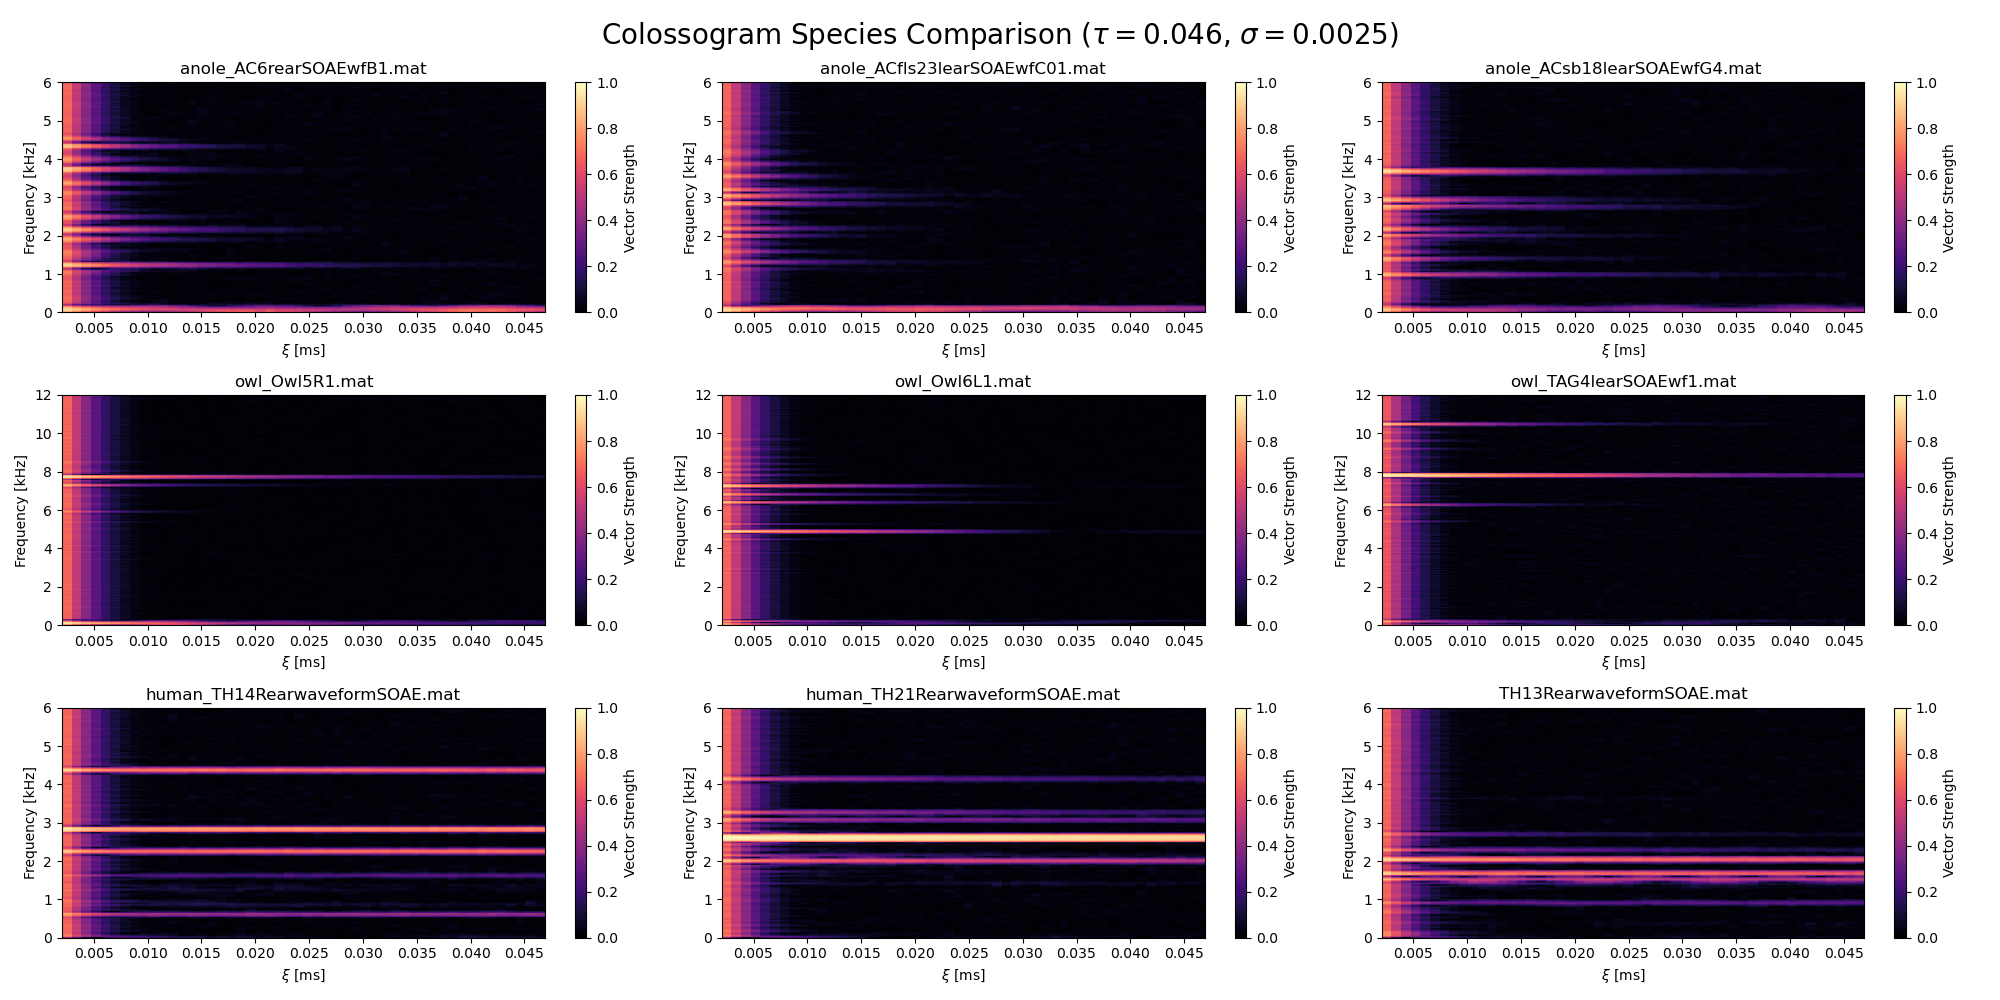

In [86]:
"Calculate and plot species comparison (sigma=0.0025)"
sigma = 0.0025
sigmaS = sigma * fs
species_coherences_list = []
for wf, fs, wf_title, species in wf_list:
    tauS = 2**11
    tau = tauS / 44100 # Everyone uses the same tau
    xis = np.linspace(0.0025, tau, 50) # And xis
    if fs != 44100: # Prioritize homogenity with other species over ideal 2**N tau
        tauS = int(tau * fs)
    max_xiS = max(xis) * fs
    f = rfftfreq(tauS, 1/fs)
    # Make sure we have a consistent number of segments to take vector strength over since this will change with xi
    N_segs = int((len(wf) - tauS) / max_xiS)    
    coherences = np.zeros((len(f), len(xis)))
    for i, xi in enumerate(xis):
        coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, win_type=("gauss", sigmaS))[1]
    species_coherences_list.append((coherences, f, xis, tau, wf_title, species))
    
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (coherences, f, xis, tau, wf_title, species) in enumerate(species_coherences_list):
    plt.subplot(3, 3, i + 1)
    if species == "Owl":
        max_khz = 12
    else:
        max_khz = 6
    colossogram(coherences, f, xis, tau, wf_title=wf_title, max_khz=max_khz)
plt.suptitle(rf'Colossogram Species Comparison ($\tau={tau:.3f}$, $\sigma = {sigma}$)', fontsize=20)
plt.tight_layout()
plt.savefig(rf'Colossogram species comparison (sigma={sigma}).png', dpi=300)
plt.show()

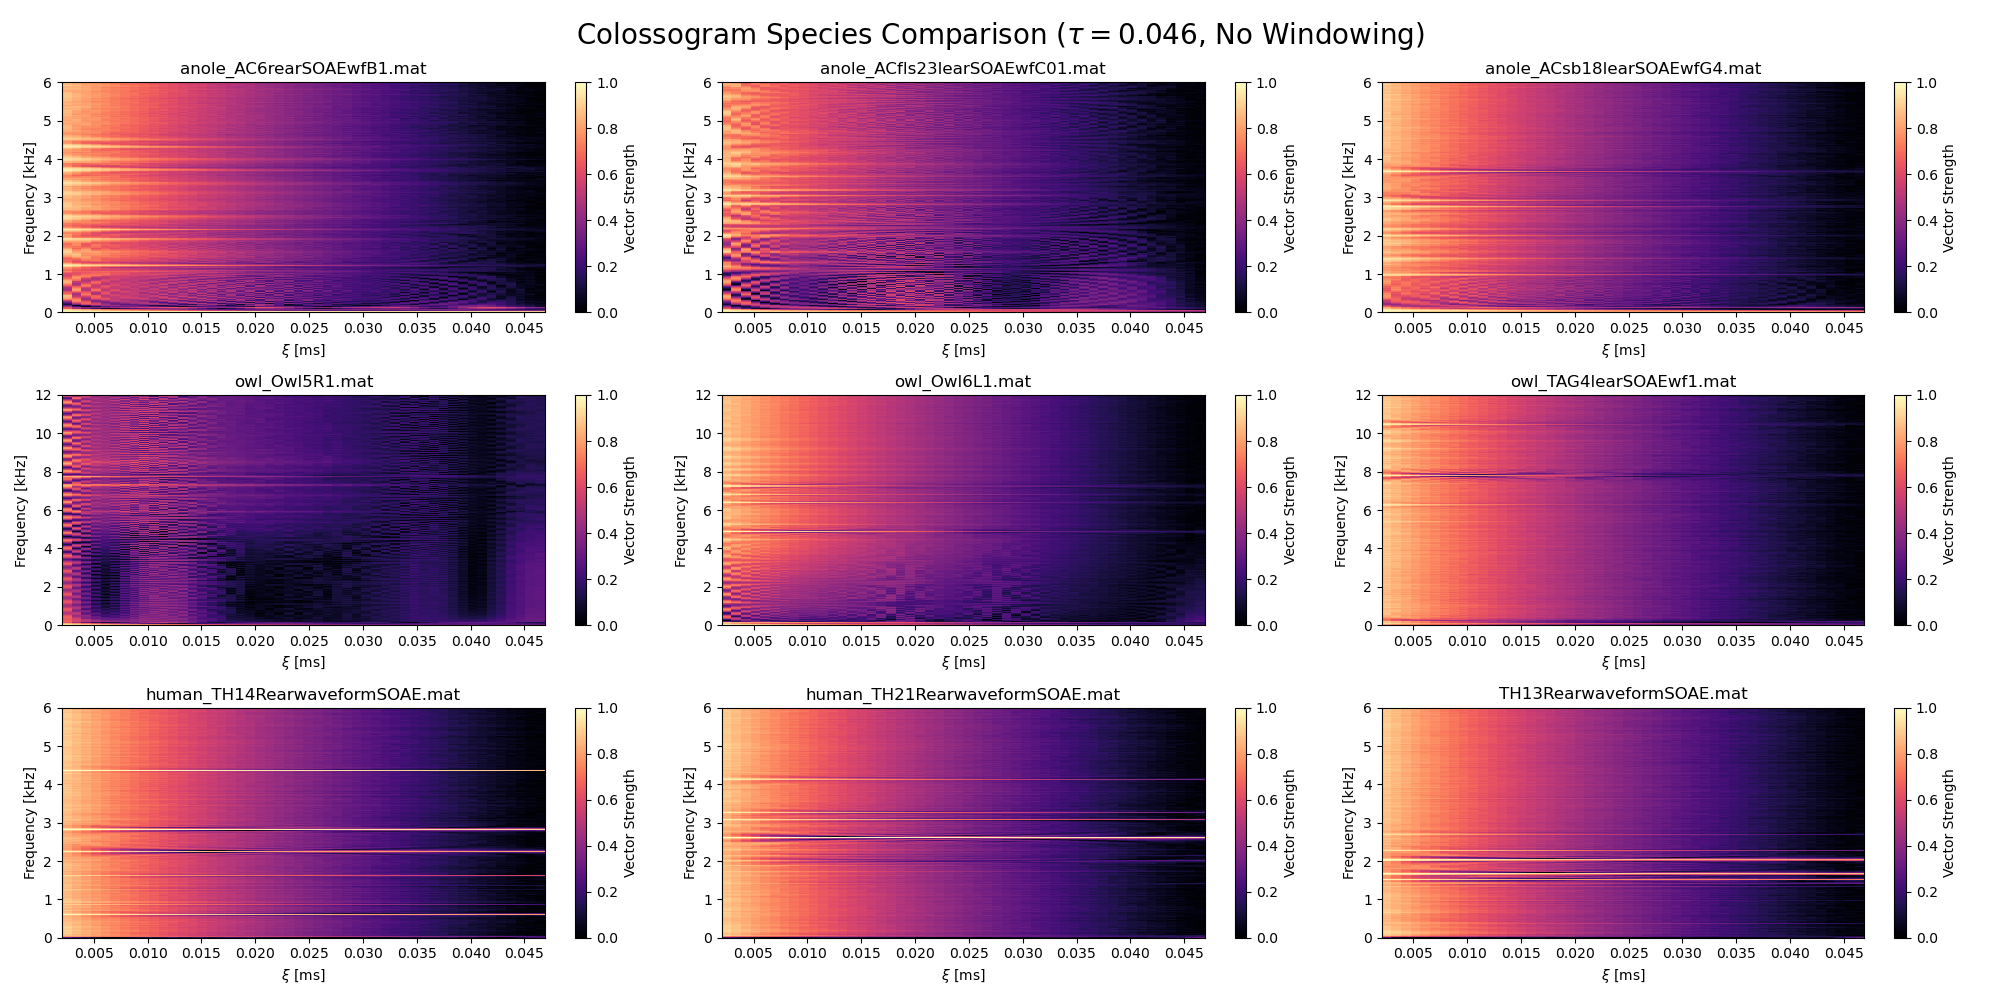

In [87]:
"Calculate and plot species comparison (no windowing)"
species_coherences_list = []
for wf, fs, wf_title, species in wf_list:
    tauS = 2**11
    tau = tauS / 44100 # Everyone uses the same tau
    xis = np.linspace(0.0025, tau, 50) # And xis
    if fs != 44100: # Prioritize homogenity with other species over ideal 2**N tau
        tauS = int(tau * fs)
    max_xiS = max(xis) * fs
    f = rfftfreq(tauS, 1/fs)
    # Make sure we have a consistent number of segments to take vector strength over since this will change with xi
    N_segs = int((len(wf) - tauS) / max_xiS)    
    coherences = np.zeros((len(f), len(xis)))
    for i, xi in enumerate(xis):
        coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs)[1]
    species_coherences_list.append((coherences, f, xis, tau, wf_title, species))
    
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (coherences, f, xis, tau, wf_title, species) in enumerate(species_coherences_list):
    plt.subplot(3, 3, i + 1)
    if species == "Owl":
        max_khz = 12
    else:
        max_khz = 6
    colossogram(coherences, f, xis, tau, wf_title=wf_title, max_khz=max_khz)
plt.suptitle(rf'Colossogram Species Comparison ($\tau={tau:.3f}$, No Windowing)', fontsize=20)
plt.tight_layout()
plt.savefig(rf'Colossogram species comparison (no windowing).png', dpi=300)
plt.show()

In [93]:
"Calculate and plot PSD species comparison"
species_psd_list = []
tau = 2**11 / 44100

for wf, fs, wf_title, species in wf_list:
    species_psd_list.append((get_welch(wf=wf, fs=fs, tau=tau, scaling="density"), wf_title, species))

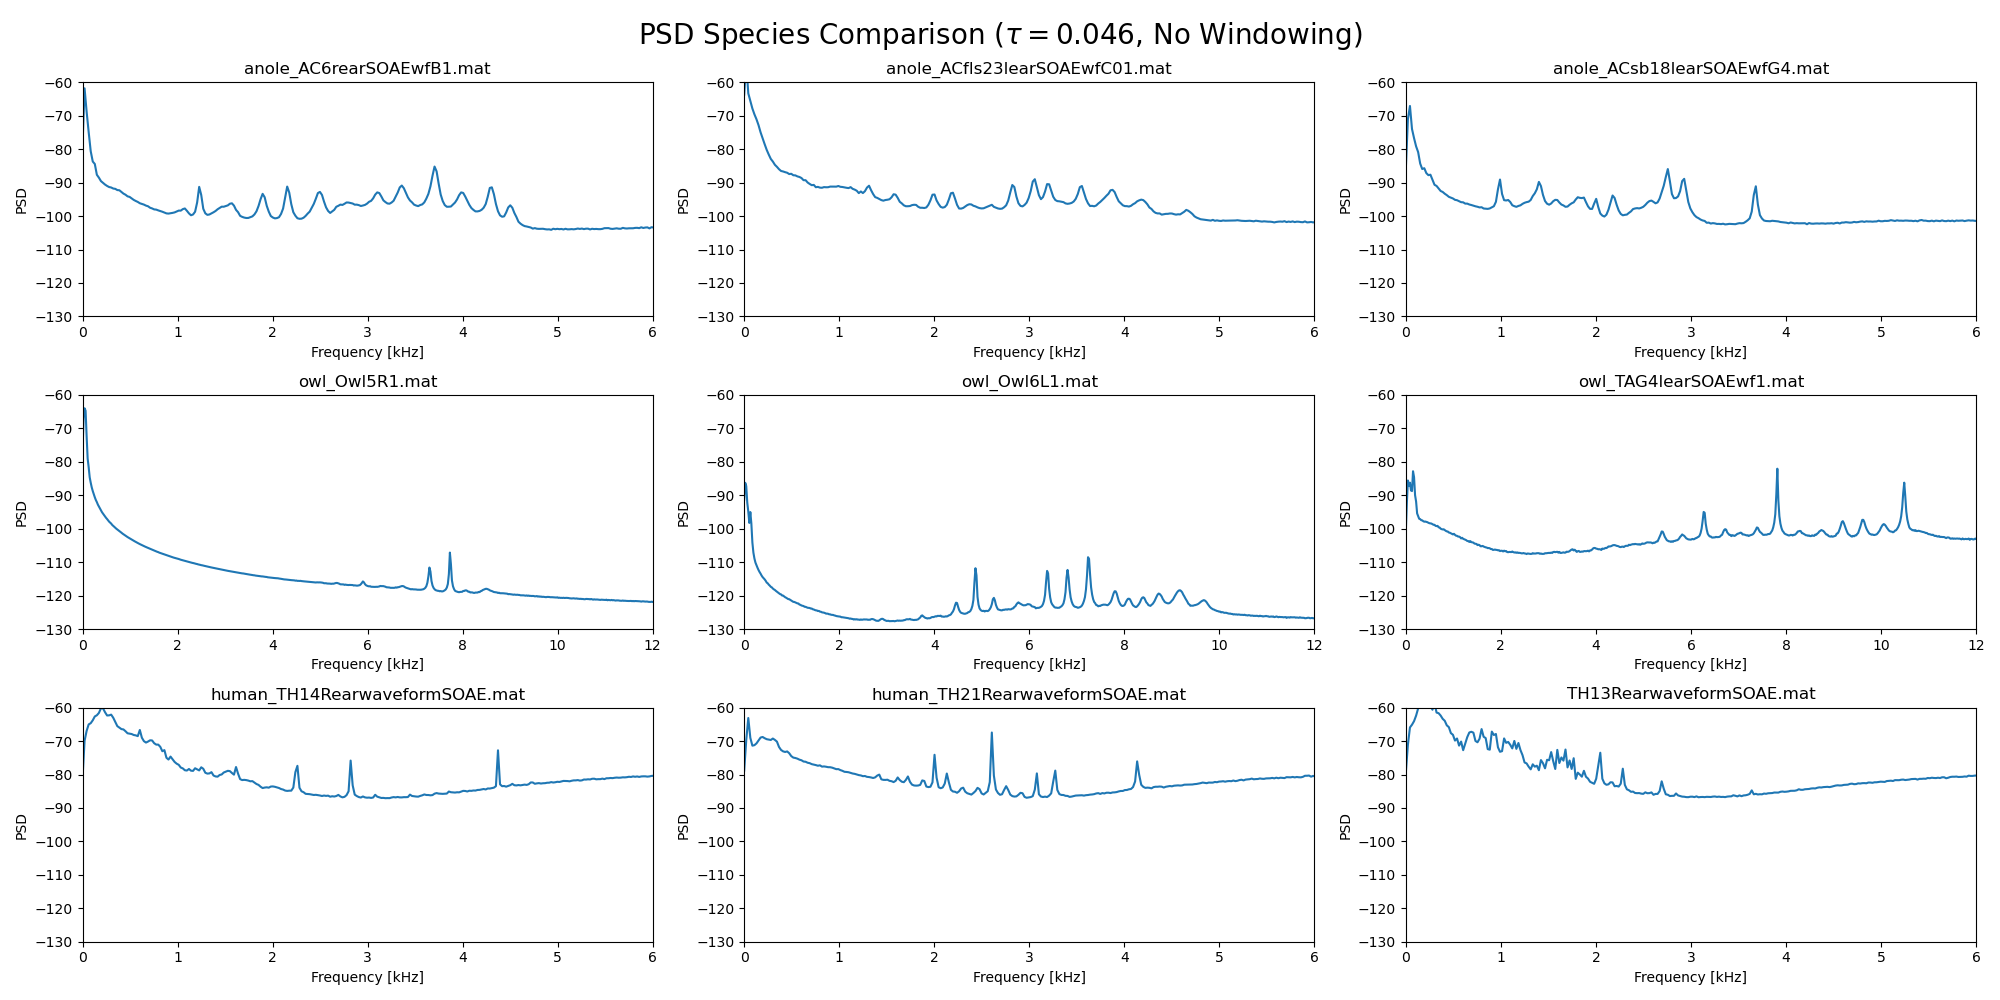

In [99]:

    
plt.close('all')
plt.figure(figsize=(20, 10))
for i, ((f, psd), wf_title, species) in enumerate(species_psd_list):
    plt.subplot(3, 3, i + 1)
    if species == "Owl":
        max_khz = 12
    else:
        max_khz = 6
    plt.plot(f/1000, 10*np.log10(psd))
    # plt.plot(f/1000, (psd))
    plt.xlim(0, max_khz)
    plt.ylim(-130, -60)
    # plt.ylim(0, 1e-8)
    plt.title(wf_title)
    plt.xlabel("Frequency [kHz]")
    plt.ylabel("PSD")
plt.suptitle(rf'PSD Species Comparison ($\tau={tau:.3f}$, No Windowing)', fontsize=20)
plt.tight_layout()
plt.savefig(rf'PSD species comparison (dB).png', dpi=300)
plt.show()